# Micro-narrative analysis of _The Lord of the Rings_

In this notebook, we try to extract "micro-narratives" from _The Lord of the Rings_ (LotR). A narrative graph provides a macro-view of a text collection, in this case three books of one series. Using community detection on the graph with PMI as edge weightings, we can extract small communities where connections between rare entities are favored due to PMI's inflation of rare events.

In [1]:
import glob
import pandas as pd
import re

docs = []
section_splitter = re.compile(
    r"(?<=\S)\n\n(?=\S)|\n{3}")  # double line break surrounded by something else than whitespace, to keep poems/songs together
for file in glob.glob("input/*.txt"):
    with open(file) as f:
        text = f.read()
        sections = section_splitter.split(text)
        for section in sections:
            section = section.strip()
            if section:
                docs.append(section)

In [2]:
from narrativegraphs import CooccurrenceGraph
from narrativegraphs.nlp.entities import SpacyEntityExtractor
from narrativegraphs.nlp.mapping import SubgramStemmingMapper
import os.path

if os.path.exists("lotr.db"):
    model = CooccurrenceGraph.load("lotr.db")
else:
    # explicit init parameters for reproducibility
    model = CooccurrenceGraph(
        entity_extractor=SpacyEntityExtractor(
            model_name="en_core_web_lg", # bigger model
            named_entities=True, # accept all named entities
            noun_chunks=(2, None)  # only two word NPs and bigger
        ),
        entity_mapper=SubgramStemmingMapper(
            head_word_type="noun",
            min_subgram_length=2,  # avoids single word entities sucking up everything
            min_subgram_frequency=2,  # also for rare entities
            min_subgram_frequency_ratio=2,  # twice as frequent to be canonical
        ),
        sqlite_db_path="lotr.db",
        n_cpu=1
    ).fit(
        docs, timestamps_ordinal=list(range(len(docs)))
    )

In [3]:
# here, we can interactively inspect the cooccurrence graph
model.serve_visualizer()

INFO:     Started server process [56953]
INFO:     Waiting for application startup.
INFO:root:Database engine provided to state before startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [56953]
INFO:root:Server stopped


## Distribution of entities

Below, we will look at the distribution of extracted entities. As for single-word distributions, we expect to be in the central Large Number of Rare Events (LNRE) zone where we see a long tail of distinct, rare entities. The number of distinct entities (our vocabulary) grows with the size of the corpus. Additionally, according to Zipf's law, we should see that the most frequent entities make up a considerable portion of the total number of entity occurrences.

We will look at both unresolved entity mentions and resolved entity mentions, but onwards we will use the resolved entities.

In [4]:
from sharedutils import fit_and_visualize_entity_frequencies

unresolved_ents_df = model.entity_mentions_.groupby("entity_span_text").size().reset_index(name="frequency")
resolved_ents_df = model.entities_

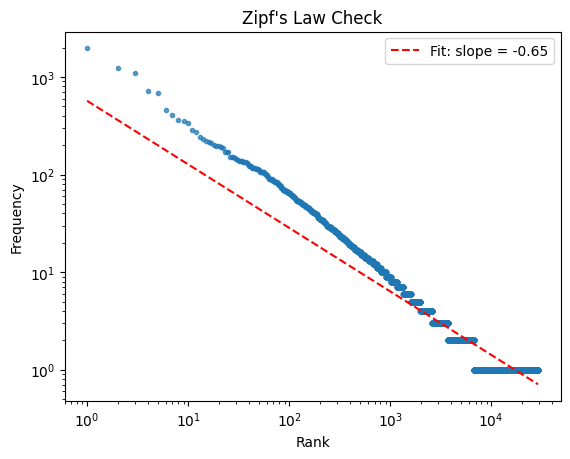

In [5]:
fit_and_visualize_entity_frequencies(unresolved_ents_df)

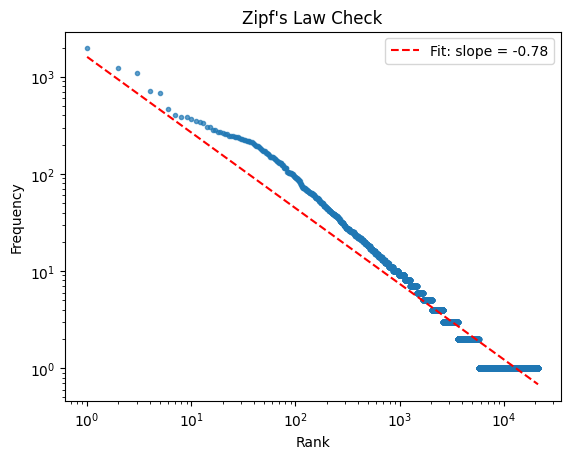

In [6]:
fit_and_visualize_entity_frequencies(resolved_ents_df)

Both roughly fit a Zipfian distribituion. The resolved entities have a slightly steeper slope as "the rich get richer" by adding lower frequency counts of some entities to other entities. Hence, the ranked list becomes shorter, but the total number of entity occurrences are the same.

In this analysis, we are interested in the lower end of the tail: the large number of rare entities. We try to see how these many distinct but rare entities fit into the narrative.

We see a significant portion of hapax legomena – single occurrence entities. While these may also be meaningful, this is also where we see the most noise from extraction errors.

In [7]:
model.entities_[model.entities_.frequency == 1]

,id,label,frequency,doc_frequency,adjusted_tf_idf,first_occurrence_ordinal,last_occurrence_ordinal,alt_labels
16,17,many glimpses,1,1,0.0,1,1,[]
19,20,its publication,1,1,0.0,1,1,[]
20,21,1937,1,1,0.0,1,1,[]
22,23,the mythology,1,1,0.0,1,1,[]
25,26,my own satisfaction,1,1,0.0,1,1,[]
...,...,...,...,...,...,...,...,...
21320,21321,the High Sea,1,1,0.0,636,636,[]
21321,21322,silver glass,1,1,0.0,636,636,[]
21322,21323,Sam the evening,1,1,0.0,636,636,[]
21323,21324,the grey sea,1,1,0.0,636,636,[]


So, from here and onwards we will consider entities with a frequency above 1.

This means that we will filter the graph as follows:

In [8]:
from narrativegraphs import GraphFilter

graph_filter = GraphFilter(
    minimum_node_frequency=2,
)

## PMI weighting of entity cooccurrences

In our fitted cooccurrence graph, we can calculate pointwise mutual information between entities $A$ and $B$:

$PMI(A, B) = \log \frac{P(A, B)}{P(A)P(B)}$

PMI is known to inflate for rare events. And more generally, it is higher for lower frequency items, as seen below.

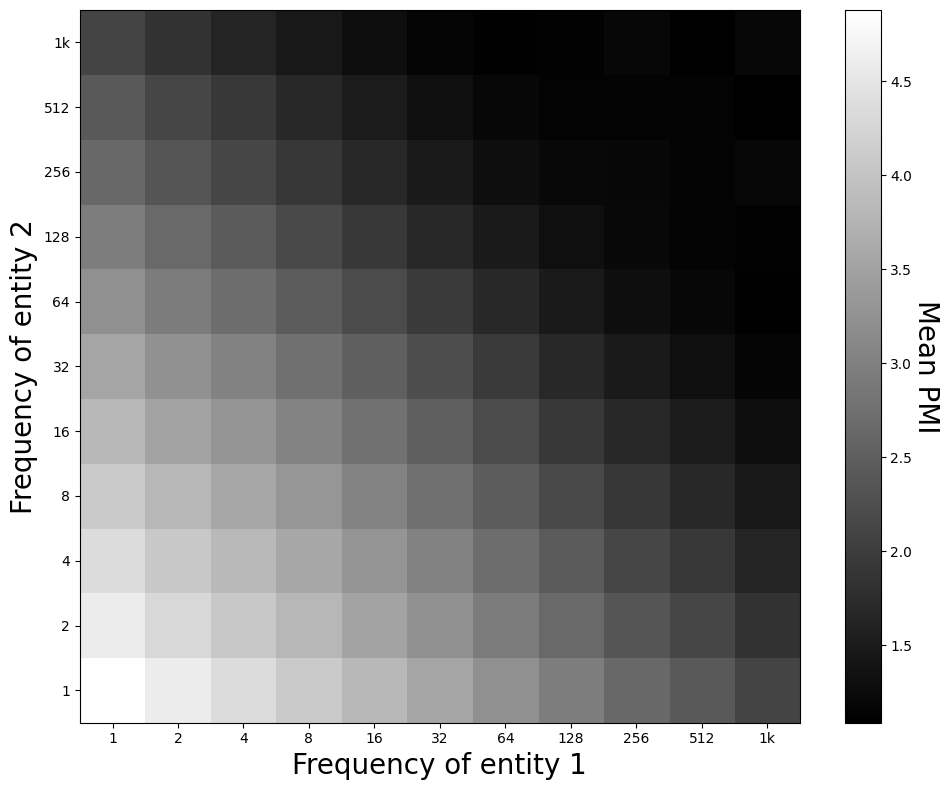

In [9]:
from sharedutils import visualize_pmi_by_frequency

visualize_pmi_by_frequency(model.cooccurrences_)

This means – one of the core hypotheses of this analysis – that if we weight edges in our graph with PMI and/or filter edges by PMI, we can surface the rare entity connections as well as particularly strong connections with the more frequent entities.

We can sort of eyeball which area we are interested in: anything above 3 will on average retain half of connections in the 200-300'ish area and therefore even more in the lower end.

In [213]:
min_weight = 2.5

## Community detection

We will use two methods, inspect their results and compare them.

k-clique community detection finds all communities of k-cliques and further merges those that share k-1 nodes. It allows for overlapping communities.

There are two hyperparameters:
- k: the minimum size of a clique. The smaller, the more small cliques we get, but the more merged cliques in bigger communities we get.
- w: the minimum weight of an edge, in our case PMI.

A thing that tends to happen according to the authors of the method is that one giant community tends to show up that eats up a lot of smaller communities and that some of this can be alleviated by tuning on the "right" hyper-parameters. But we may also interpret this differently: this giant community means that whatever micro-narratives are in there are not sufficiently delimited from the general narrative. We will keep this community on the side and not mix them in with the rest of the smaller ones.

We let k=4 to allow for small meaningful communities. k=2 essentially yields connected components (since it merges all connected nodes) and is therefore too small. k=3 also results in too many cliques being merged into one giant community.

In [214]:
k_clique_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=min_weight,
    community_detection_method_args=dict(k=4)
)

k_clique_comms_with_contexts = []
k_clique_big_comms = []
last_size = None
for comm in sorted(k_clique_comms, key=lambda c: len(c.members)):
    size = len(comm.members)
    if size < 2:
        continue
    if last_size and size > 2 * last_size:
        k_clique_big_comms.append(comm)
        continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    k_clique_comms_with_contexts.append((comm, contexts))
    last_size = size

print(len(k_clique_big_comms))
print(*[len(comm.members) for comm in k_clique_big_comms], sep=', ')

1
4312


Louvain community detection finds communities by optimizing towards modularity, merging smaller communities into bigger ones iteratively while modularity increases. It creates non-overlapping communities.

There are several hyper-parameters, but we consider only:
- resolution: higher values result in smaller communities.

The NetworkX implementation of Louvain considers edge weights, so we need not filter by PMI but rather leave the weighting to the algorithm.

In [215]:
louvain_comms = model.graph.find_communities(
    graph_filter=graph_filter,
    min_weight=None,
    community_detection_method="louvain",
    community_detection_method_args=dict(resolution=35)
)
louvain_comms_with_contexts = []

for comm in sorted(louvain_comms, key=lambda c: c.score, reverse=True):
    size = len(comm.members)
    if size < 2 or size > 1000: continue
    contexts = model.tuplets.get_contexts_by_entity_ids(comm.member_ids)
    contexts.sort(key=lambda c: c.doc_id)
    louvain_comms_with_contexts.append((comm, contexts))

Let us get a sense of what kinds of communities we get from the two methods.

## Comparison of k-clique and Louvain

In [216]:
comms_by_method = {
    "k_clique": k_clique_comms_with_contexts,
    "louvain": louvain_comms_with_contexts
}

In [217]:
import numpy as np

# Extract sizes for each method
sizes_by_method = {
    method: [len(comm.members) for comm, contexts in comms_with_contexts]
    for method, comms_with_contexts in comms_by_method.items()
}

for name, comms in sizes_by_method.items():
    print(name)
    print("N:", len(comms))
    print("Mean:", np.mean(comms))
    print("Min:", np.min(comms))
    print("Q1:", np.quantile(comms, .25))
    print("Median:", np.median(comms))
    print("Q3:", np.quantile(comms, .75))
    print("Max:", np.max(comms))
    print()


k_clique
N: 1571
Mean: 7.249522597071929
Min: 4
Q1: 4.0
Median: 6.0
Q3: 8.0
Max: 58

louvain
N: 791
Mean: 7.035398230088496
Min: 2
Q1: 4.0
Median: 6.0
Q3: 9.0
Max: 26



After fiddling with hyperparameters, we see that we have landed at a place where the sizes of the communities are comparable. We can see their distribution here.

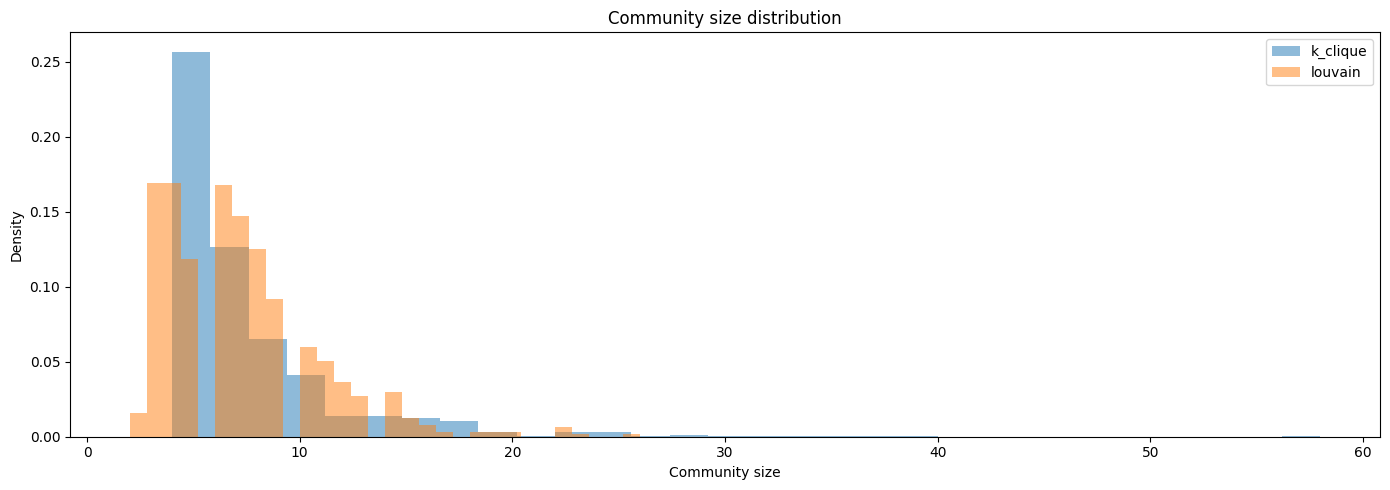

In [218]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 5))

# Barplot: distribution of community sizes
x = np.arange(len(comms_by_method))
width = 0.35

# Density plot: full distributions
for method, sizes in sizes_by_method.items():
    ax.hist(sizes, bins=30, alpha=0.5, label=method, density=True)

ax.set_xlabel('Community size')
ax.set_ylabel('Density')
ax.set_title('Community size distribution')
ax.legend()

plt.tight_layout()
plt.show()

So why, when they are of comparable sizes, are there so many more in k-clique? Due to overlap between communities.

In [219]:
from collections import Counter
k_clique_membership_counter = Counter(e.id for comm in k_clique_comms for e in comm.members)

In [220]:
print('Mean membership', np.mean(list(k_clique_membership_counter.values())))
print('Median membership', np.median(list(k_clique_membership_counter.values())))

Mean membership 2.8315599639314697
Median membership 2.0


It would also be interesting to see how much they overlap, i.e. if the communties from one algorithm is mostly contained by the communites from the other.

In [221]:
def coverage(list_a: list[set], list_b: list[set]) -> float:
    scores = []
    lengths = []
    for a in list_a:
        if not a:
            continue
        best = max(len(a & b) / len(a) for b in list_b)
        scores.append(best)
        lengths.append(len(a))
    return sum(score * length for score, length in zip(scores, lengths)) / sum(lengths)


k_clique_comm_sets = [{e.id for e in comm.members} for comm, _ in k_clique_comms_with_contexts]
louvain_comm_sets = [{e.id for e in comm.members} for comm, _ in louvain_comms_with_contexts]
k_clique_big_comm_sets = [{e.id for e in comm.members} for comm in k_clique_big_comms]
print("k-clique covered by Louvain:", coverage(k_clique_comm_sets, louvain_comm_sets))
print("Louvain covered by k-clique:", coverage(louvain_comm_sets, k_clique_comm_sets))
print("Louvain covered by giant k-clique comm:", coverage(louvain_comm_sets, k_clique_big_comm_sets))

k-clique covered by Louvain: 0.30652383879181666
Louvain covered by k-clique: 0.4316262353998203
Louvain covered by giant k-clique comm: 0.7518418688230009


Finding some examples where they overlap but not fully.

In [222]:
def best_overlap(a: set[int], list_b: list[set[int]]):
    best = None
    best_index = None
    best_score = 0
    for i, b in enumerate(list_b):
        score = len(a & b) / len(a)
        if score > best_score:
            best = b
            best_index = i
            best_score = score
    return i, best_score



They seem to produce quite different communities, given this low overlap, though it is somewhat speculative.

In [223]:
import random
random.seed(42)

for name, comm_with_contexts in [("k-clique", k_clique_comms_with_contexts), ("louvain", louvain_comms_with_contexts)]:
    print(name)
    sample = random.choices(comm_with_contexts, k=10)
    for comm, contexts in sample:
        print_comm_with_contexts(comm, contexts)

k-clique
COMMUNITY: his breath, a force, the efforts, his reckoning, more than one passage, a will, such things
ID: 445, OFFSET: 1202
While they were still able to give heed to such things, they could hear his breath hissing and gasping just in front of them. But after a time their senses became duller, both touch and hearing seemed to grow numb, and they kept on, groping, walking, on and on, mainly by the force of the will with which they had entered, will to go through and desire to come at last to the high gate beyond.
Before they had gone very far, perhaps, but time and distance soon passed out of his reckoning, Sam on the right, feeling the wall, was aware that there was an opening at the side: for a moment he caught a faint breath of some air less heavy, and then they passed it by.
'There's more than one passage here,' he whispered with an effort: it seemed hard to make his breath give any sound. `It's as orc-like a place as ever there could be! '
After that, first he on the righ

## Typology of communities

Intuitively, the micro-narratives can appear in a few ways, with these as reference points on a two-dimensional continuum.

1. Appear once
2. Appear a few times in close vicinity
3. Appear multiple times in close vicinity
4. Appear a few times with great distance
5. Appear multiple times with great distance

From the earlier qualitative assessment, we saw that many appeared in just one short context snippet in one section of the book. These make up the bulk of the extracted micro-narratives.

In [224]:
def spike_analysis(comms_with_contexts):
    spike_values, spread_values = [], []
    for comm, contexts in comms_with_contexts:
        ids = {c.doc_id for c in contexts}
        spike_values.append(len(ids))
        spread_values.append(max(ids) - min(ids) + 1)

    return spike_values, spread_values

In [225]:
k_clique_spikes, k_clique_spread = spike_analysis(k_clique_comms_with_contexts)
louvain_spikes, louvain_spread = spike_analysis(louvain_comms_with_contexts)

### Single-spike micro-narratives

In [226]:
# k-clique single-spike
sum(1 for sv in k_clique_spikes if sv == 1)

632

In [227]:
# louvain single-spike
sum(1 for sv in louvain_spikes if sv == 1)

314

In [228]:
from sharedutils import print_comm_with_contexts

def single_spike_sample(comms_with_contexts, spike_values, n_print=5):
    printed = 0
    for (comm, contexts), sv in zip(k_clique_comms_with_contexts, spike_values):
        if sv > 1: continue
        print_comm_with_contexts(comm, contexts)
        print()
        printed += 1
        if printed >= n_print:
            break

We can dig qualitatively into some of these:

In [229]:
single_spike_sample(k_clique_comms_with_contexts, k_clique_spikes)

COMMUNITY: some fashion, The trail, such need, Mortal Men
ID: 220, OFFSET: 10322
There are few among mortal Men who know more of Orcs; and I do not hunt them in this fashion out of choice. The Orcs whom we pursued took captive two of my friends. In such need a man that has no horse will go on foot, and he will not ask for leave to follow the trail. Nor will he count the heads of the enemy save with a sword. I am not weaponless.'
Aragorn threw back his cloak.


COMMUNITY: the White Hand, Dwimordene, Mortal Men, White
ID: 283, OFFSET: 5986


     In Dwimordene, in Lórien
      Seldom have walked the feet of Men,
      Few mortal eyes have seen the light
      That lies there ever, long and bright.
      Galadriel! Galadriel!
      Clear is the water of your well;
      White is the star in your white hand;
      Unmarred, unstained is leaf and land
      In Dwimordene, in Lórien
      More fair than thoughts of Mortal Men.


COMMUNITY: each member, little hope, 'Leagues, our trail
ID: 16

In [230]:
single_spike_sample(louvain_comms_with_contexts, louvain_spikes)

COMMUNITY: Bilbo Baggins, the variety, other parts, Many people
ID: 22, OFFSET: 2330

Bilbo Baggins called it a _party,_ but it was really a variety of entertainments rolled into one. Practically everybody living near was invited. A very few were overlooked by accident, but as they turned up all the same, that did not matter. Many people from other parts of the Shire were also asked; and there were even a few from outside the borders. Bilbo met the guests (and additions) at the new white gate in person. He gave away presents to all and sundry  the latter were those who went out again by a back way and came in again by the gate. Hobbits give presents to other people on their own birthdays.
ID: 22, OFFSET: 15587

As for Bilbo Baggins, even while he was making his speech, he had been fingering the golden ring in his pocket: his magic ring that he had kept secret for so many years. As he stepped down he slipped it on his finger, and he was never seen by any hobbit in Hobbiton again.
He wa

These do indeed appear to be small clusters of rather specific mentions of rare entities. When one thinks about it, it makes sense that these surface as communities in a PMI-weighted graph: they are the rare connections of rare entities.

### Multi-spike micro-narratives

We will now dig into multi-spike micro-narratives and see how they are distributed in terms of spread and spikes.

We will operationalize spread as the floored log10 value. This reflects the order of magnitude of sections that a community spreads. Spikes are operationalized as the floored log2 value. This gives us a sort of scale of pair-few-multiple-many.

In [2]:
from sharedutils import multi_spike_df, multi_spike_heatmap

In [232]:
k_clique_df = multi_spike_df(k_clique_spikes, k_clique_spread)

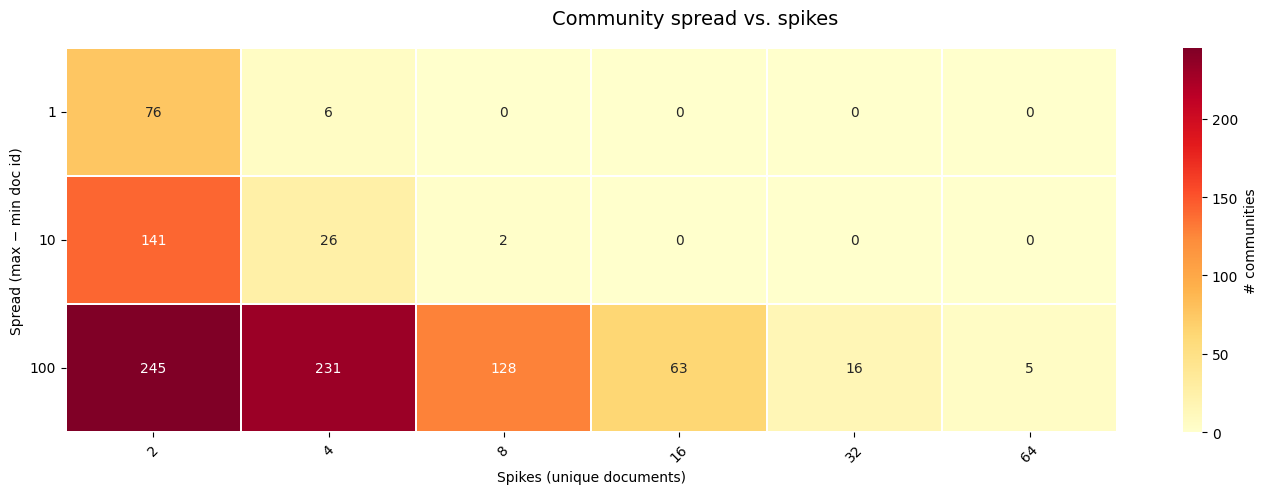

In [233]:
multi_spike_heatmap(k_clique_df)

In [234]:
louvain_df = multi_spike_df(louvain_spikes, louvain_spread)

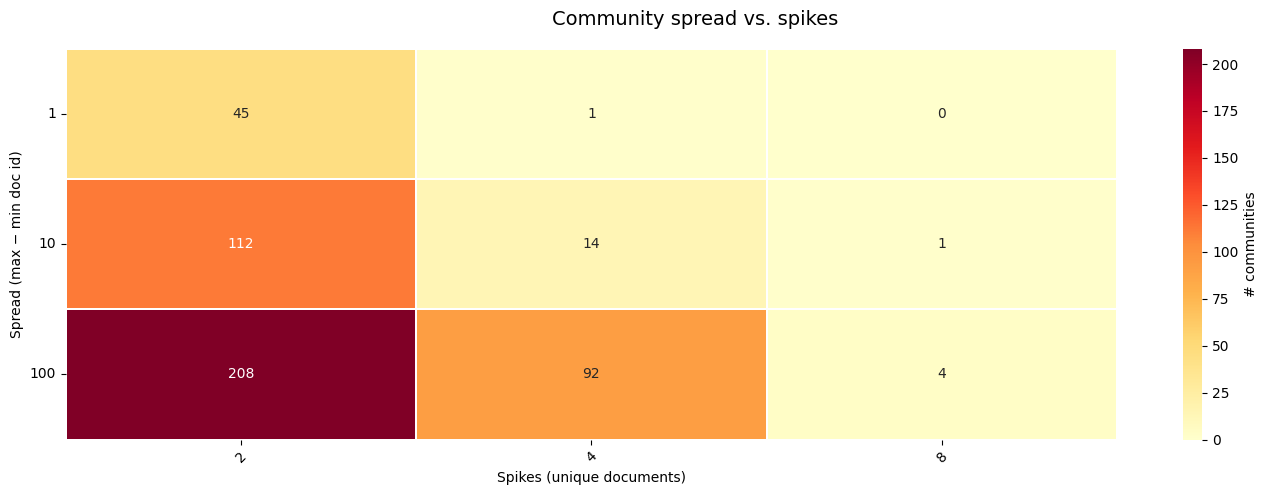

In [235]:
multi_spike_heatmap(louvain_df)

The spread of the communities seem highly comparable, but the number of spikes for the Louvain communities appear to be much lower.

We will try to dig into these blocks and assess qualitatively what is extracted. This is meant to be done interactively, not stay as output in the notebook. Therefore, there is just example usage below.

In [3]:
from sharedutils import activation_score, slice_micro_narratives, print_micro_narratives

ImportError: cannot import name 'activation_score' from 'sharedutils' (/Users/au479461/PycharmProjects/narrative-graph/examples/micro-narratives/sharedutils.py)

#### Low spread, few spikes

In [237]:
# Top-left cell: low spread and few spikes
# print_micro_narratives(k_clique_comms_with_contexts, k_clique_df, 2, 10, 2, 4)

In [238]:
# print_micro_narratives(louvain_comms_with_contexts, louvain_df, 2, 4, 2, 4)

#### Moderate spread, few spikes
They generally seem to amount to "cross-textual echoes", a re-activation of something from earlier.

In [263]:
# print_micro_narratives(k_clique_comms_with_contexts, k_clique_df, 10, 100, 2, 4)

In [240]:
# print_micro_narratives(louvain_comms_with_contexts, louvain_df, 10, 100, 2, 4)

#### High spread, few spikes
They generally seem to amount to "cross-textual echoes", a re-activation of something from much earlier. Some are genuinely interesting, others appear more like noise.

In [264]:
# print_micro_narratives(k_clique_comms_with_contexts, k_clique_df, 100, 1000, 2, 4)

In [255]:
# print_micro_narratives(louvain_comms_with_contexts, louvain_df, 100, 1000, 2, 4)

#### Low-moderate spread, multiple spikes
These are somewhat more persistent communities across three or more sections, but still limited in the text. These generally amount to atmospheres, world-building details or sub-plots.

In [1]:
# print_micro_narratives(k_clique_comms_with_contexts, k_clique_df, 2, 30, 4, 100)

In [253]:
# print_micro_narratives(louvain_comms_with_contexts, louvain_df, 2, 100, 4, 100)

#### High spread, multiple spikes
These generally amount to recurring narrative elements and motifs and a few sub-plots

In [245]:
# print_micro_narratives(k_clique_comms_with_contexts, k_clique_df, 100, 1000, 4, 16)

In [251]:
# print_micro_narratives(louvain_comms_with_contexts, louvain_df, 2, 100, 4, 16)

#### High spread, many spikes

Only for k-clique. These mostly amount to noise from generic nouns tying too much together. Frequency-wise, we are also moving out of the area that can be considered "micro". Parts of the communities are recognizable as meaningful sub-plots.

In [247]:
# print_micro_narratives(k_clique_comms_with_contexts, k_clique_df, 100, 1000, 16, 100)

We see general tendencies in the cells that correspond to the earlier mentioned reference points. We will regard these as prototypes of micro-narratives in terms of their spikes and spread. We call them:

- Episodic: low spread
- Echoing: high spread, few spikes
- Recurring: high spread, multiple spikes